# An extensive Time Series tutorial

### Import libraries to work with

In [525]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM2D, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, TimeDistributed, Input
from keras.layers.merge import concatenate
from keras.utils import plot_model

### Load the data

In [384]:
input_data = pd.read_csv('inputs.csv',header=None)
output_data = pd.read_csv('outputs.csv',header=None)
input_data = abs(input_data)

In [385]:
input_data.shape

(1000, 3)

In [386]:
input_data.head()

,0,1,2
0,1253.688798,43.459183,0.081048
1,1253.658489,1.849287,0.104586
2,1253.682101,88.224989,0.110097
3,1253.691660,81.198326,0.143408
4,1253.638780,122.391441,0.168541


In [387]:
output_data.shape

(1000, 1)

In [388]:
output_data.head()

,0
0,-0.662891
1,-0.006388
2,-0.613494
3,-0.664729
4,0.175758


### Check for unexpected (missing, infinite etc.) values

In [389]:
np.isnan(input_data.iloc[:,0]).any()

False

In [390]:
np.isnan(input_data.iloc[:,1]).any()

False

In [391]:
np.isnan(input_data.iloc[:,2]).any()

False

In [392]:
np.isfinite(input_data.iloc[:,0]).all()

True

In [393]:
np.isfinite(input_data.iloc[:,1]).all()

True

In [394]:
np.isfinite(input_data.iloc[:,2]).all()

True

## Two-stage Stationarity check process

It is time to check whether the data are stationary or not in order to move on properly. We are going to use two statistical tests to evaluate the stationarity of our data given that our null hypothesis in both cases (which we try to reject) is that the time series are non-stationary: i) Augmented Dickey-Fuller test ii) KPSS test

We are going to evaluate each variable separately to stationarise it, if necessary. This is due to the multivariate time-series we have got.

**NOTE!:** It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

***Case 1:*** Both tests conclude that the series is not stationary -> series is not stationary

***Case 2:*** Both tests conclude that the series is stationary -> series is stationary

***Case 3:*** KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

***Case 4:*** KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [395]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    roll_mean = timeseries.rolling(12).mean()
    roll_std = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    ### Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    
    # The number of lags is chosen to minimise the Akaike's Information Criterion (AIC)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    print('\n\n')
    
    ### Perform KPSS test:
    print ('Results of KPSS Test:')
    
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

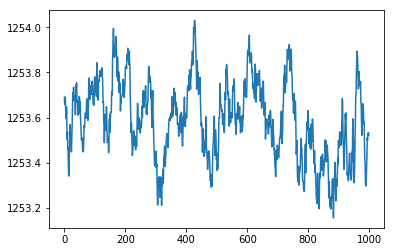

In [396]:
plt.plot(input_data.iloc[:,0])

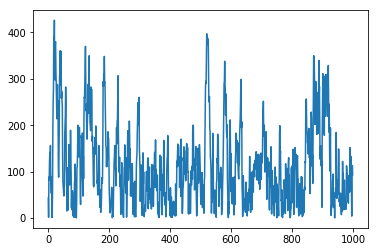

In [397]:
plt.plot(input_data.iloc[:,1])

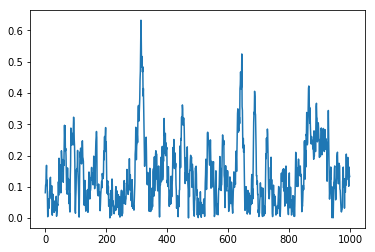

In [398]:
plt.plot(input_data.iloc[:,2])

**Note!:** At this point empirically we can say that the Time-Series are in a stationary format. However, it goes without saying that we will verify this empirical assumption made at a first glance by statistical methods.

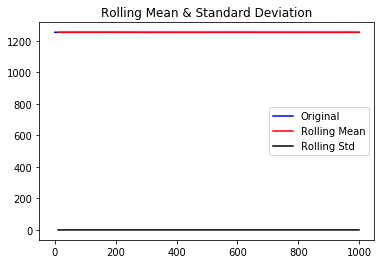

Results of Dickey-Fuller Test:
Test Statistic                  -4.718431
p-value                          0.000078
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64



Results of KPSS Test:
Test Statistic            0.742531
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [399]:
test_stationarity(input_data.iloc[:,0])

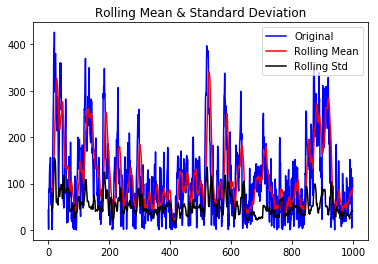

Results of Dickey-Fuller Test:
Test Statistic                -8.844294e+00
p-value                        1.636522e-14
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.232385
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [400]:
test_stationarity(input_data.iloc[:,1])

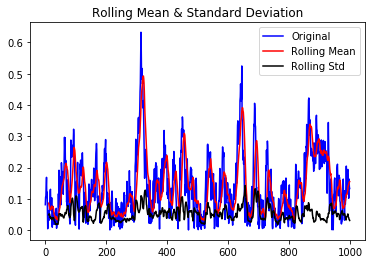

Results of Dickey-Fuller Test:
Test Statistic                -6.170838e+00
p-value                        6.811625e-08
#Lags Used                     8.000000e+00
Number of Observations Used    9.910000e+02
Critical Value (1%)           -3.436966e+00
Critical Value (5%)           -2.864461e+00
Critical Value (10%)          -2.568325e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.10538
p-value                   0.10000
Lags Used                22.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [401]:
test_stationarity(input_data.iloc[:,2])

**Corollary:** According to the statistic tests we implemented, we can say that we strongly reject our null hypothesis - due to the very small p-values - which means that our Time-Series are stationary. That being said, we can move onto the next stage of our process to develop the predictive regression model.

### Hypothetical case (Non-stationary data)

If the Time-Series were non-stationary, then we would follow the following process to bring them into the proper format:

*i) We would apply a transformation (e.g. logarithmic transformation) to the Time-Series to reduce trend.*

*ii) In case the Time-Series were also sufficiently noisy, we would need to estimate and model the trend by smoothing for example (or by aggregating or polynomial fitting). Indicatively, we could work with an exponentially weighted moving average (or other kind of moving average).*

*iii) If the situation had not been resolved yet, then we could have used differencing (of first order, for instance) or decomposing (e.g. seasonal decomposition) to eliminate trend and seasonality which Time-Series more often than not suffer from.*

After those steps, we would eventually have ended up with fine Time-Series to work with.

### Log transformation

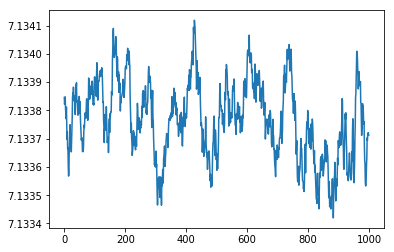

In [402]:
input_data.iloc[:,0] = np.log(input_data.iloc[:,0])
log_input0 = input_data.iloc[:,0]
plt.plot(input_data.iloc[:,0])

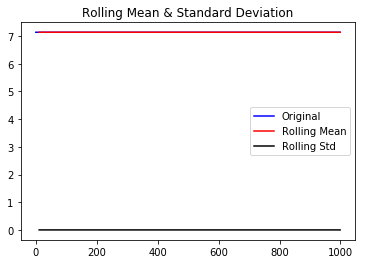

Results of Dickey-Fuller Test:
Test Statistic                  -4.718450
p-value                          0.000078
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64



Results of KPSS Test:
Test Statistic            0.74258
p-value                   0.01000
Lags Used                22.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [403]:
test_stationarity(input_data.iloc[:,0])

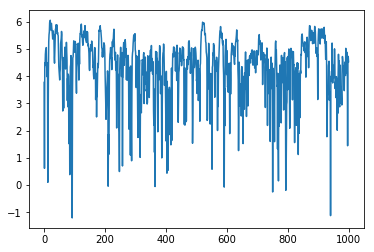

In [404]:
input_data.iloc[:,1] = np.log(input_data.iloc[:,1])
log_input1 = input_data.iloc[:,1]
plt.plot(input_data.iloc[:,1])

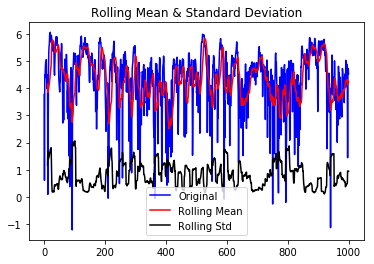

Results of Dickey-Fuller Test:
Test Statistic                -7.163323e+00
p-value                        2.929525e-10
#Lags Used                     9.000000e+00
Number of Observations Used    9.900000e+02
Critical Value (1%)           -3.436973e+00
Critical Value (5%)           -2.864464e+00
Critical Value (10%)          -2.568327e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.167307
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [405]:
test_stationarity(input_data.iloc[:,1])

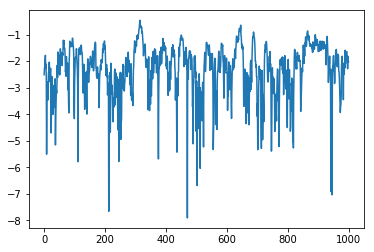

In [406]:
input_data.iloc[:,2] = np.log(input_data.iloc[:,2])
log_input2 = input_data.iloc[:,2]
plt.plot(input_data.iloc[:,2])

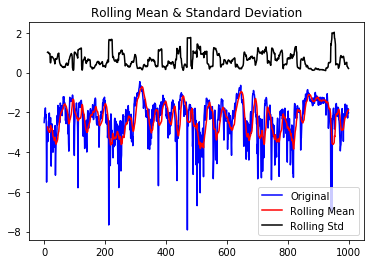

Results of Dickey-Fuller Test:
Test Statistic                -8.204748e+00
p-value                        7.073998e-13
#Lags Used                     3.000000e+00
Number of Observations Used    9.960000e+02
Critical Value (1%)           -3.436933e+00
Critical Value (5%)           -2.864446e+00
Critical Value (10%)          -2.568317e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.087012
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [407]:
test_stationarity(input_data.iloc[:,2])

## Approach #1

### Exponentially-Weighted Moving Average

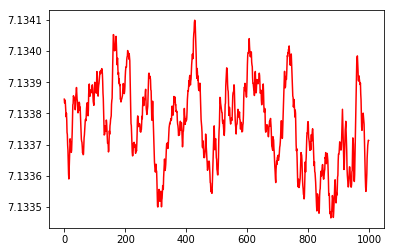

In [55]:
input_data.iloc[:,0] = input_data.iloc[:,0].ewm(halflife=1, adjust=False).mean()

plt.figure()
# plt.plot(log_input0, color='blue')
plt.plot(input_data.iloc[:,0], color='red')
plt.show()

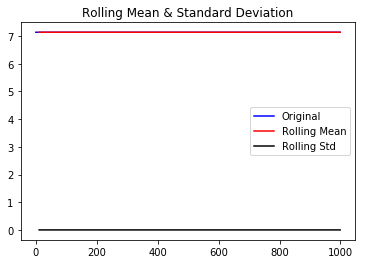

Results of Dickey-Fuller Test:
Test Statistic                  -4.750517
p-value                          0.000068
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64



Results of KPSS Test:
Test Statistic            0.748413
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [56]:
test_stationarity(input_data.iloc[:,0].dropna(inplace=False))

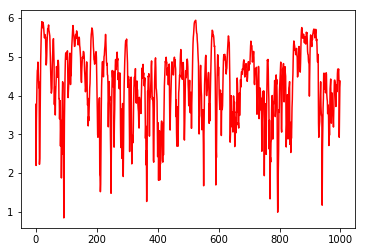

In [57]:
input_data.iloc[:,1] = input_data.iloc[:,1].ewm(halflife=1, adjust=False).mean()

plt.figure()
# plt.plot(log_input0, color='blue')
plt.plot(input_data.iloc[:,1], color='red')
plt.show()

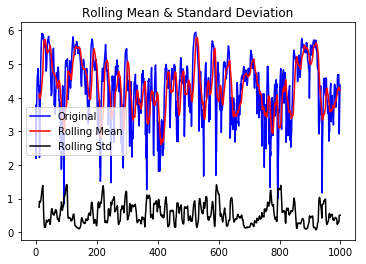

Results of Dickey-Fuller Test:
Test Statistic                -9.248373e+00
p-value                        1.515591e-15
#Lags Used                     2.000000e+00
Number of Observations Used    9.970000e+02
Critical Value (1%)           -3.436926e+00
Critical Value (5%)           -2.864443e+00
Critical Value (10%)          -2.568316e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.167995
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [58]:
test_stationarity(input_data.iloc[:,1])

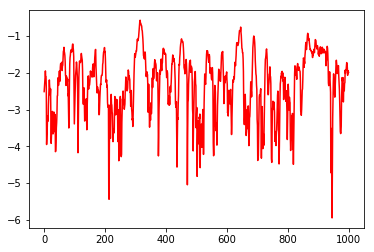

In [59]:
input_data.iloc[:,2] = input_data.iloc[:,2].ewm(halflife=1, adjust=False).mean()

plt.figure()
# plt.plot(log_input0, color='blue')
plt.plot(input_data.iloc[:,2], color='red')
plt.show()

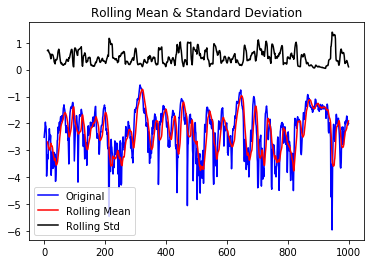

Results of Dickey-Fuller Test:
Test Statistic                -8.112816e+00
p-value                        1.212988e-12
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.087816
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [60]:
test_stationarity(input_data.iloc[:,2])

## Approach #2

### Differencing

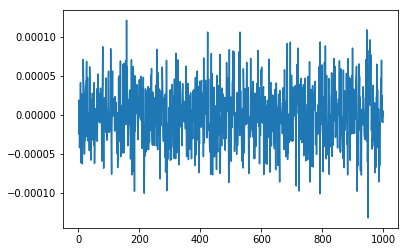

In [489]:
diff_input0 = log_input0 - log_input0.shift()
plt.plot(diff_input0)

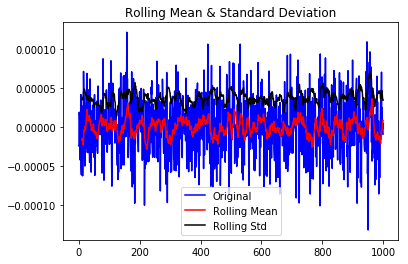

Results of Dickey-Fuller Test:
Test Statistic                 -30.030266
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64



Results of KPSS Test:
Test Statistic            0.014643
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [491]:
test_stationarity(diff_input0.fillna(method='ffill').fillna(method='bfill'))

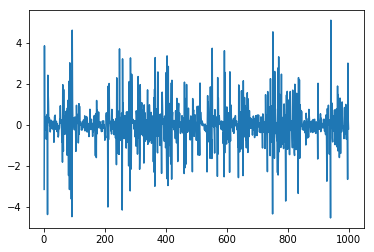

In [492]:
diff_input1 = log_input1 - log_input1.shift()
plt.plot(diff_input1)

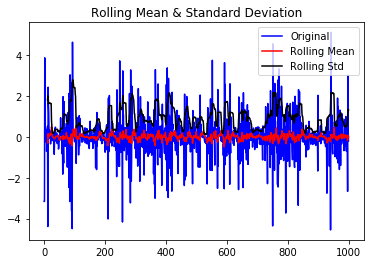

Results of Dickey-Fuller Test:
Test Statistic                -1.006739e+01
p-value                        1.285511e-17
#Lags Used                     2.200000e+01
Number of Observations Used    9.770000e+02
Critical Value (1%)           -3.437061e+00
Critical Value (5%)           -2.864503e+00
Critical Value (10%)          -2.568348e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.032892
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [493]:
test_stationarity(diff_input1.fillna(method='ffill').fillna(method='bfill'))

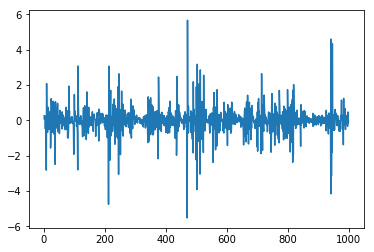

In [494]:
diff_input2 = log_input2 - log_input2.shift()
plt.plot(diff_input2)

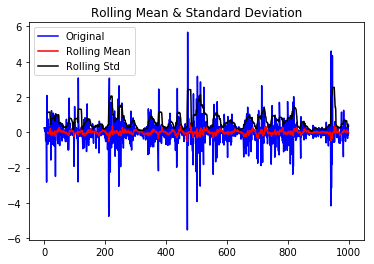

Results of Dickey-Fuller Test:
Test Statistic                -9.717336e+00
p-value                        9.750396e-17
#Lags Used                     2.200000e+01
Number of Observations Used    9.770000e+02
Critical Value (1%)           -3.437061e+00
Critical Value (5%)           -2.864503e+00
Critical Value (10%)          -2.568348e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.01144
p-value                   0.10000
Lags Used                22.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [495]:
test_stationarity(diff_input2.fillna(method='ffill').fillna(method='bfill'))

### Seasonal decomposition

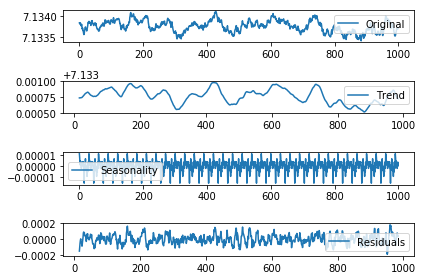

In [219]:
decomposition = seasonal_decompose(input_data.iloc[:,0].values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(input_data.iloc[:,0].values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

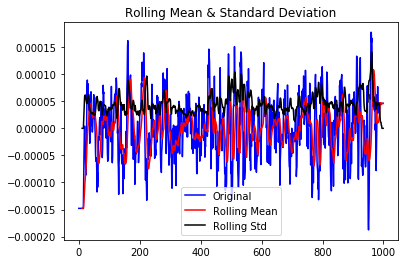

Results of Dickey-Fuller Test:
Test Statistic                -1.112512e+01
p-value                        3.389254e-20
#Lags Used                     5.000000e+00
Number of Observations Used    9.940000e+02
Critical Value (1%)           -3.436946e+00
Critical Value (5%)           -2.864452e+00
Critical Value (10%)          -2.568321e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.204167
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [220]:
input_data.iloc[:,0] = residual
test_stationarity(input_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill'))

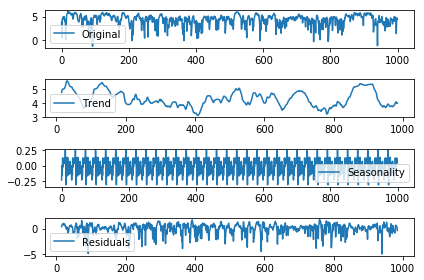

In [221]:
decomposition = seasonal_decompose(input_data.iloc[:,1].values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(input_data.iloc[:,1].values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

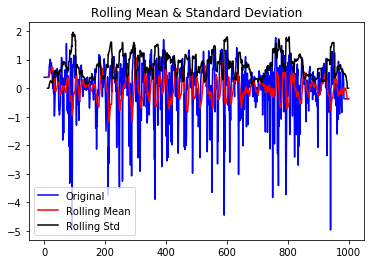

Results of Dickey-Fuller Test:
Test Statistic                -1.011882e+01
p-value                        9.564518e-18
#Lags Used                     2.200000e+01
Number of Observations Used    9.770000e+02
Critical Value (1%)           -3.437061e+00
Critical Value (5%)           -2.864503e+00
Critical Value (10%)          -2.568348e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.118248
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [222]:
input_data.iloc[:,1] = residual
test_stationarity(input_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill'))

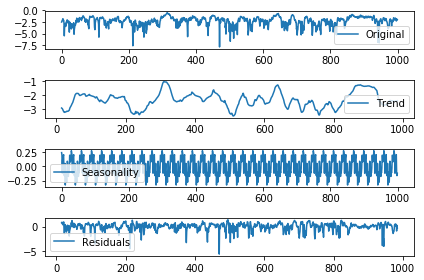

In [223]:
decomposition = seasonal_decompose(input_data.iloc[:,2].values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(input_data.iloc[:,2].values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

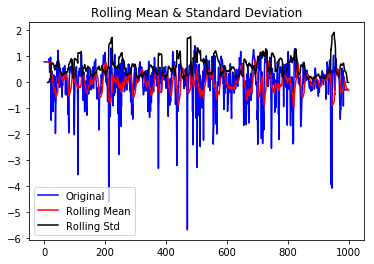

Results of Dickey-Fuller Test:
Test Statistic                -1.043092e+01
p-value                        1.611599e-18
#Lags Used                     2.200000e+01
Number of Observations Used    9.770000e+02
Critical Value (1%)           -3.437061e+00
Critical Value (5%)           -2.864503e+00
Critical Value (10%)          -2.568348e+00
dtype: float64



Results of KPSS Test:
Test Statistic            0.095541
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [224]:
input_data.iloc[:,2] = residual
test_stationarity(input_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill'))

## Data manipulation

In [225]:
col0 = input_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill').copy()
col1 = input_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill').copy()
col2 = input_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill').copy()
input_data = input_data.iloc[0:0]
input_data.iloc[:,0] = col0
input_data.iloc[:,1] = col1
input_data.iloc[:,2] = col2

In [408]:
X = input_data.values
y = output_data.values

In [409]:
X = StandardScaler().fit_transform(X)

In [410]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

kf = TimeSeriesSplit(n_splits=4) 
kf.get_n_splits(X)

4

In [411]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [412]:
input_data.shape

(1000, 3)

## Lasso regression model

The first model I developed is a Cross-Validated (for the alpha parameter) Lasso model using the Least Angle Regression (LARS) to benefit from more accurate exploration for the alpha parameter.

Fold: # 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


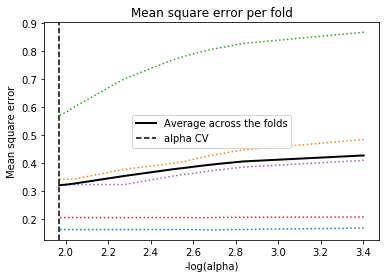

Fold: # 2


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


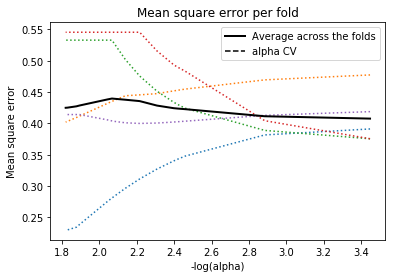

Fold: # 3


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


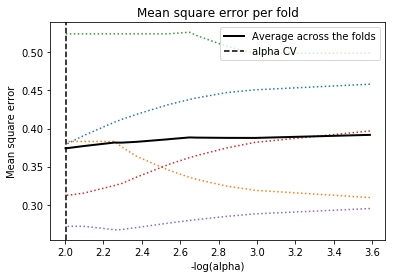

Fold: # 4


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


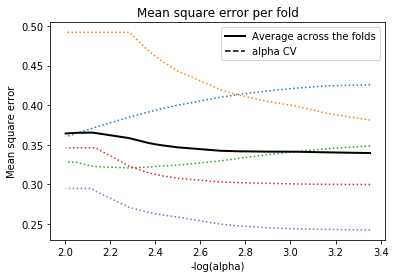

In [413]:
lasso_r2_scores = []
lasso_mse_scores = []

i = 0

for train_index, test_index in kf.split(X,y):
    print('Fold: #',i+1)
        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Lasso training
    lasso_model = LassoLarsCV(cv=5).fit(X_train, np.ravel(y_train))
    
    # Lasso scores
    lasso_r2_scores.append(lasso_model.score(X_test, np.ravel(y_test)))
    lasso_mse_scores.append(mean_squared_error(np.ravel(y_test),lasso_model.predict(X_test)))
    
    # Lasso results
    m_log_alphas = -np.log10(lasso_model.cv_alphas_)

    plt.figure()
    plt.plot(m_log_alphas, lasso_model.mse_path_, ':')
    plt.plot(m_log_alphas, lasso_model.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(lasso_model.alpha_), linestyle='--', color='k',
                label='alpha CV')
    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error per fold')
    plt.axis('tight')

    plt.show()
    
    i += 1

In [414]:
print('Average R2 score of Lasso-LARS model is: ', np.mean(lasso_r2_scores))
print('Average MSE of Lasso-LARS model is: ', np.mean(lasso_mse_scores))

Average R2 score of Lasso-LARS model is:  -0.045711128989184
Average MSE of Lasso-LARS model is:  0.38107876623635145


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

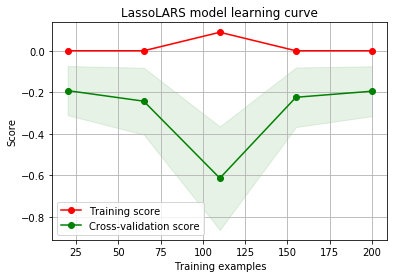

In [415]:
plot_learning_curve(LassoLarsCV(cv=5), 'LassoLARS model learning curve', X, np.ravel(y), cv=TimeSeriesSplit(n_splits=4))

## Support Vector Machine regression model

The second attempt will be done by using a SVR model with Gaussian kernels to cope with the higher dimensionality of our case.

In [416]:
svr_r2_scores = []
svr_mse_scores = []

i = 0
penalty = 10

for train_index, test_index in kf.split(X,y):
    print('Fold: #',i+1)
        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    svr_estimator = SVR(C=penalty, gamma='auto')

    # SVM training
    svr_model = svr_estimator.fit(X_train, np.ravel(y_train))
    
    # SVM scores
    svr_r2_scores.append(svr_model.score(X_test, np.ravel(y_test)))
    svr_mse_scores.append(mean_squared_error(np.ravel(y_test),svr_model.predict(X_test)))
    
    i += 1

Fold: # 1
Fold: # 2
Fold: # 3
Fold: # 4


In [417]:
print('Average R2 score of SVR model is: ', np.mean(svr_r2_scores))
print('Average MSE of SVR model is: ', np.mean(svr_mse_scores))

Average R2 score of SVR model is:  0.3997119273781
Average MSE of SVR model is:  0.22429138485411043


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

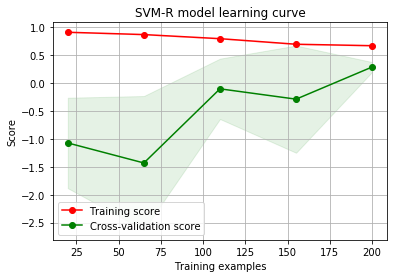

In [418]:
plot_learning_curve(SVR(C=penalty, gamma='auto'), 'SVM-R model learning curve', X, np.ravel(y), cv=TimeSeriesSplit(n_splits=4))

## Gradient Boosting with regression trees regression model

Fold: # 1
Fold: # 2
Fold: # 3
Fold: # 4


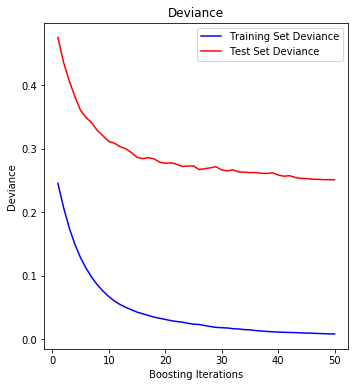

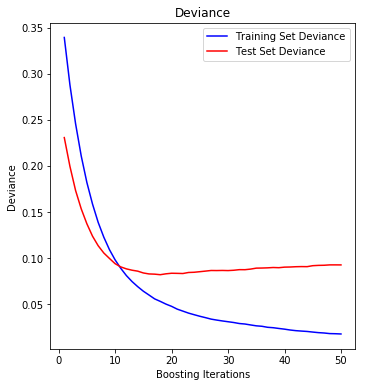

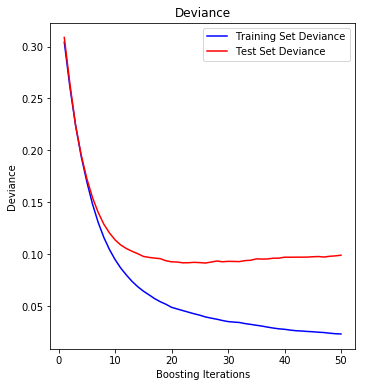

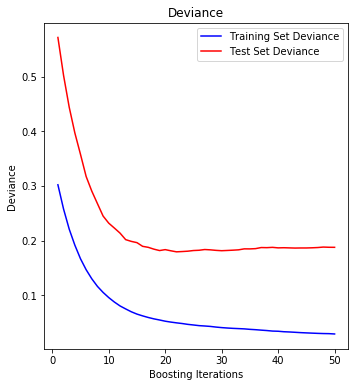

In [422]:
grad_boost_r2_scores = []
grad_boost_mse_scores = []

k = 0

num_estimators = 50
maximum_depth = 5

for train_index, test_index in kf.split(X,y):
    print('Fold: #',k+1)
        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    grad_boost_estimator = GradientBoostingRegressor(n_estimators=num_estimators,
                                          criterion='friedman_mse',
                                          max_depth=maximum_depth,
                                          verbose=0)

    # Gradient Boosting training
    grad_boost_model = grad_boost_estimator.fit(X_train, np.ravel(y_train))
    
    # Gradient Boosting scores
    grad_boost_r2_scores.append(grad_boost_model.score(X_test, np.ravel(y_test)))
    grad_boost_mse_scores.append(mean_squared_error(np.ravel(y_test),grad_boost_model.predict(X_test)))
    
    # Plot training deviance

    # Compute test set deviance
    test_score = np.zeros((num_estimators,), dtype=np.float32)

    for i, y_pred in enumerate(grad_boost_estimator.staged_predict(X_test)):
        test_score[i] = grad_boost_estimator.loss_(np.ravel(y_test), y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(num_estimators) + 1, grad_boost_estimator.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(num_estimators) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    
    k += 1

In [423]:
print('Average R2 score of Gradient Boosting model is: ', np.mean(grad_boost_r2_scores))
print('Average MSE of Gradient Boosting model is: ', np.mean(grad_boost_mse_scores))

Average R2 score of Gradient Boosting model is:  0.5977457224508183
Average MSE of Gradient Boosting model is:  0.15752459450734516


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

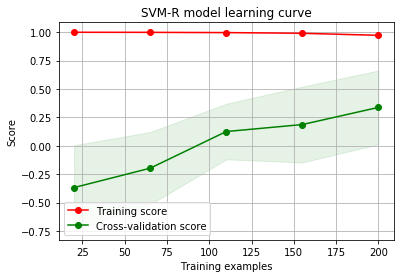

In [424]:
plot_learning_curve(GradientBoostingRegressor(n_estimators=num_estimators,
                                              criterion='friedman_mse',
                                              max_depth=maximum_depth,
                                              verbose=0), 
                    'SVM-R model learning curve', X, np.ravel(y), cv=TimeSeriesSplit(n_splits=4))

## Multi-Layer Perceptron (Deep Neural Network architecture)

### Further Data Preprocessing

At this point, we will not use TimeSeriesSplit anymore. Instead, we will split training and test sets explicitly. At the same time, instead of using one-step models, we will use a larger look-back model and thus, a different preprocessing is required.

A rather simple DNN will be developed below consissting of fully connected layers and dropout layers. Although for this dataset, the use of Dropout layers may be an overkill, this model architecture has been mainly designed for demonstration purposes and not for achieving the optimal performance. Besides, we have not gone so far and will not go below for a Hyperparameter optimisation.

In [425]:
y = np.ravel(y)
feat1 = X[:,0]
feat2 = X[:,1]
feat3 = X[:,2]

In [426]:
def look_back_split(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

In [427]:
thres = int(len(X)*0.8)

feat1_train = feat1[:thres]
feat2_train = feat2[:thres]
feat3_train = feat3[:thres]

feat1_test = feat1[thres:]
feat2_test = feat2[thres:]
feat3_test = feat3[thres:]

y_train = y[:thres]
y_test = y[thres:]

look_back = 3

In [428]:
training_data = np.transpose(np.vstack((feat1_train, feat2_train, feat3_train, y_train))).astype('float32')
test_data = np.transpose(np.vstack((feat1_test, feat2_test, feat3_test, y_test))).astype('float32')

In [429]:
training_data.shape

(800, 4)

In [430]:
training_data[:5,:]

array([[ 0.5868427 , -0.46043745, -0.17915933, -0.66289055],
       [ 0.4077027 , -3.2338612 ,  0.07560207, -0.00638751],
       [ 0.54726106,  0.16159588,  0.12690707, -0.61349446],
       [ 0.6037624 ,  0.08868475,  0.3910165 , -0.66472924],
       [ 0.2912125 ,  0.4491569 ,  0.5523685 ,  0.1757584 ]],
      dtype=float32)

In [431]:
test_data.shape

(200, 4)

In [432]:
test_data[:5,:]

array([[ 0.09443452,  0.37265977,  0.24973878,  0.49918887],
       [-0.0778761 ,  0.19948608,  0.39680153,  0.499162  ],
       [-0.61797243,  0.33037075, -0.34888458, -0.11898148],
       [-0.4462164 ,  0.61658114, -1.089687  ,  0.24191034],
       [-0.48510176,  0.59845746, -0.73705214,  0.07555294]],
      dtype=float32)

In [433]:
X_train, y_train = look_back_split(training_data,3)
X_test, y_test = look_back_split(test_data,3)

In [434]:
X_train[:5,:]

array([[0.5868427 , 0.4077027 , 0.54726106],
       [0.4077027 , 0.54726106, 0.6037624 ],
       [0.54726106, 0.6037624 , 0.2912125 ],
       [0.6037624 , 0.2912125 , 0.18783428],
       [0.2912125 , 0.18783428, 0.02936583]], dtype=float32)

In [435]:
y_train[:5]

array([0.6037624 , 0.2912125 , 0.18783428, 0.02936583, 0.33701408],
      dtype=float32)

### Model design

In [436]:
mlp_model = Sequential()
mlp_model.add(Dense(128, input_dim=look_back, activation='relu'))
mlp_model.add(Dropout(0.25))
mlp_model.add(Dense(8, activation='relu'))
mlp_model.add(Dense(1))

In [437]:
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


In [438]:
mlp_model.compile(loss='mean_squared_error', optimizer='adam')

### Model training

In [439]:
history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_test, y_test))

Train on 796 samples, validate on 196 samples
Epoch 1/100
796/796 [==============================] - 1s 964us/step - loss: 0.2071 - val_loss: 0.1099
Epoch 2/100
796/796 [==============================] - 0s 165us/step - loss: 0.1056 - val_loss: 0.1001
Epoch 3/100
796/796 [==============================] - 0s 223us/step - loss: 0.1016 - val_loss: 0.0999
Epoch 4/100
796/796 [==============================] - 0s 179us/step - loss: 0.0976 - val_loss: 0.0943
Epoch 5/100
796/796 [==============================] - 0s 225us/step - loss: 0.0887 - val_loss: 0.0993
Epoch 6/100
796/796 [==============================] - 0s 174us/step - loss: 0.0884 - val_loss: 0.0977
Epoch 7/100
796/796 [==============================] - 0s 250us/step - loss: 0.0866 - val_loss: 0.0937
Epoch 8/100
796/796 [==============================] - 0s 196us/step - loss: 0.0879 - val_loss: 0.1451
Epoch 9/100
796/796 [==============================] - 0s 210us/step - loss: 0.0890 - val_loss: 0.0964
Epoch 10/100
796/796 [=====

796/796 [==============================] - 0s 166us/step - loss: 0.0789 - val_loss: 0.0949
Epoch 80/100
796/796 [==============================] - 0s 138us/step - loss: 0.0770 - val_loss: 0.0983
Epoch 81/100
796/796 [==============================] - 0s 168us/step - loss: 0.0787 - val_loss: 0.1012
Epoch 82/100
796/796 [==============================] - 0s 156us/step - loss: 0.0748 - val_loss: 0.1036
Epoch 83/100
796/796 [==============================] - 0s 164us/step - loss: 0.0766 - val_loss: 0.0972
Epoch 84/100
796/796 [==============================] - 0s 159us/step - loss: 0.0785 - val_loss: 0.1037
Epoch 85/100
796/796 [==============================] - 0s 158us/step - loss: 0.0760 - val_loss: 0.0965
Epoch 86/100
796/796 [==============================] - 0s 159us/step - loss: 0.0742 - val_loss: 0.1150
Epoch 87/100
796/796 [==============================] - 0s 159us/step - loss: 0.0737 - val_loss: 0.0948
Epoch 88/100
796/796 [==============================] - 0s 159us/step - loss:

### Model evaluation

In [440]:
score = mlp_model.evaluate(X_test, y_test, verbose=1)

196/196 [==============================] - 0s 180us/step


In [441]:
print('The MSE on the test set is: ', score)

The MSE on the test set is:  0.09584619275921462


### Plot results

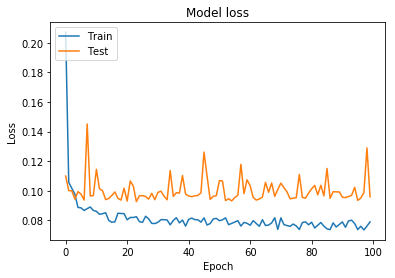

In [442]:
# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Multi-stream ConvLSTM regression model

Below we will design a DNN consisting of Convolutional, Pooling, LSTM, Dropout and fully connected layers. It will be a multi-stream architecture. More specifically, we assume that the data are of different frequency and hence,  we need to process them separately into separate streams.

I remind that I opted for this architecture only for demonstrating a different more sophisticated architecture which is flexible and effective for many similar problems.

### Data preprocessing

Again, we need to design an different data engineering process due to the different approach we are going to design. Now, we are going to handle mixed kinds of sequences; uni- and multi-variate sequences per steps. Thus, we will need to split all those sequences before feeding our data into our model

In [443]:
# univariate_seq = X[:,0]
# multivariate_seq = X[:,1:]
y = np.ravel(y) # run this command unless the MLP above has not been executed
# thres = int(len(X)*0.8)
# X_train_uni = univariate_seq[:thres]
# X_test_uni = univariate_seq[thres:]
# X_train_multi = multivariate_seq[:thres,:]
# X_test_multi = multivariate_seq[thres:,:]
# y_train = y[:thres]
# y_test = y[thres:]

In [444]:
def split_multivariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [445]:
# y = np.ravel(y) # run this command unless the MLP above has not been executed
feat1 = X[:,0]
feat2 = X[:,1]
feat3 = X[:,2]

In [446]:
thres = int(len(X)*0.8)

feat1_train = feat1[:thres]
feat2_train = feat2[:thres]
feat3_train = feat3[:thres]

feat1_test = feat1[thres:]
feat2_test = feat2[thres:]
feat3_test = feat3[thres:]

y_train = y[:thres]
y_test = y[thres:]

In [447]:
stream1_train = np.transpose(np.vstack((feat2_train, y_train))).astype('float32')
stream2_train = np.transpose(np.vstack((feat3_train, y_train))).astype('float32')
stream1_test = np.transpose(np.vstack((feat2_test, y_test))).astype('float32')
stream2_test = np.transpose(np.vstack((feat3_test, y_test))).astype('float32')

In [448]:
n_steps = 2
X_train_stream1, y_train_stream1 = split_multivariate_sequence(stream1_train, n_steps)
X_train_stream2, y_train_stream2 = split_multivariate_sequence(stream2_train, n_steps)
X_test_stream1, y_test_stream1 = split_multivariate_sequence(stream1_test, n_steps)
X_test_stream2, y_test_stream2 = split_multivariate_sequence(stream2_test, n_steps)

In [449]:
# X_train_stream1 = feat1_train
# X_test_stream1 = feat1_test

In [450]:
X_train_stream1.shape

(799, 2, 1)

In [451]:
X_train_stream2.shape

(799, 2, 1)

In [452]:
n_features = 1
n_seq = 1
n_steps = 2

# For ConvLSTM2D use this reshape
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
# X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
X_train_stream1 = X_train_stream1.reshape((X_train_stream1.shape[0], n_seq, 1, n_steps, n_features))
X_train_stream2 = X_train_stream2.reshape((X_train_stream2.shape[0], n_seq, 1, n_steps, n_features))
X_test_stream1 = X_test_stream1.reshape((X_test_stream1.shape[0], n_seq, 1, n_steps, n_features))
X_test_stream2 = X_test_stream2.reshape((X_test_stream2.shape[0], n_seq, 1, n_steps, n_features))

# For explicit use of CNN and LSTM use this reshape and move on as usual
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# X_train_stream1 = X_train_stream1.reshape((X_train_stream1.shape[0], 2, 1, 1))
# X_train_stream2 = X_train_stream2.reshape((X_train_stream2.shape[0], 2, 2, 1))
# X_test_stream1 = X_test_stream1.reshape((X_test_stream1.shape[0], 2, 1, 1))
# X_test_stream2 = X_test_stream2.reshape((X_test_stream2.shape[0], 2, 2, 1))

In [453]:
X_train_stream1.shape

(799, 1, 1, 2, 1)

In [454]:
X_train_stream2.shape

(799, 1, 1, 2, 1)

In [455]:
assert y_train_stream1.all() == y_train_stream2.all(), 'Wrong splitting!'
y_train = y_train_stream1 # Or y_train_stream2 can be also assigned to y_train since they are the same vectors.

In [456]:
assert y_test_stream1.all() == y_test_stream2.all(), 'Wrong splitting!'
y_test = y_test_stream1 # Or y_test_stream2 can be also assigned to y_test since they are the same vectors.

In [457]:
y_train.shape

(799,)

In [458]:
X_train_stream1 = np.array(X_train_stream1)
X_train_stream2 = np.array(X_train_stream2)
X_test_stream1 = np.array(X_test_stream1)
X_test_stream2 = np.array(X_test_stream2)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [459]:
X_train_stream1.shape

(799, 1, 1, 2, 1)

In [460]:
X_train_stream2.shape

(799, 1, 1, 2, 1)

### Model design

In [461]:
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))

In [477]:
# Stream 1
input1 = Input(shape=(None, 1, n_steps, n_features))
conv1 = ConvLSTM2D(32, kernel_size=(1,n_steps), activation='relu')(input1)
dropout11 = Dropout(0.25)(conv1)
flat1 = Flatten()(dropout11)
dense1 = Dense(64, activation='relu')(flat1)
dropout12 = Dropout(0.25)(dense1)

# Stream 2
input2 = Input(shape=(None, 1, n_steps, n_features))
conv2 = ConvLSTM2D(32, kernel_size=(1,n_steps), activation='relu')(input2)
dropout21 = Dropout(0.25)(conv2)
flat2 = Flatten()(dropout21)
dense2 = Dense(64, activation='relu')(flat2)
dropout22 = Dropout(0.25)(dense2)

# Interpolation
concat = concatenate([dropout12, dropout22])
dense = Dense(8, activation='relu')(concat)

# Output
final_dense = Dense(1)(dense)

conv_lstm_model = Model(inputs=[input1, input2], outputs=final_dense)

In [478]:
conv_lstm_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 1, 2, 1 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, 1, 2, 1 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)     (None, 1, 1, 32)     8576        input_9[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D)    (None, 1, 1, 32)     8576        input_10[0][0]                   
__________________________________________________________________________________________________
dropout_19

In [479]:
conv_lstm_model.compile(optimizer='adam', loss='mse')

### Model training

In [486]:
multi_history = conv_lstm_model.fit([X_train_stream1, X_train_stream2], y_train, epochs=50, batch_size=8, verbose=1, validation_data=([X_test_stream1, X_test_stream2], y_test))

Train on 799 samples, validate on 199 samples
Epoch 1/50
799/799 [==============================] - 0s 522us/step - loss: 0.2940 - val_loss: 0.7038
Epoch 2/50
799/799 [==============================] - 0s 462us/step - loss: 0.2898 - val_loss: 0.6928
Epoch 3/50
799/799 [==============================] - 0s 451us/step - loss: 0.2932 - val_loss: 0.7079
Epoch 4/50
799/799 [==============================] - 0s 456us/step - loss: 0.2880 - val_loss: 0.7087
Epoch 5/50
799/799 [==============================] - 0s 460us/step - loss: 0.2951 - val_loss: 0.7026
Epoch 6/50
799/799 [==============================] - 0s 448us/step - loss: 0.2844 - val_loss: 0.6862
Epoch 7/50
799/799 [==============================] - 0s 456us/step - loss: 0.2882 - val_loss: 0.6899
Epoch 8/50
799/799 [==============================] - 0s 461us/step - loss: 0.2855 - val_loss: 0.7241
Epoch 9/50
799/799 [==============================] - 0s 451us/step - loss: 0.2883 - val_loss: 0.7167
Epoch 10/50
799/799 [===============

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246619). Check your callbacks.
  % delta_t_median)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123760). Check your callbacks.
  % delta_t_median)


799/799 [==============================] - 1s 881us/step - loss: 0.2894 - val_loss: 0.7163
Epoch 35/50
799/799 [==============================] - 0s 450us/step - loss: 0.2918 - val_loss: 0.7065
Epoch 36/50
799/799 [==============================] - 0s 447us/step - loss: 0.2877 - val_loss: 0.7024
Epoch 37/50
799/799 [==============================] - 1s 790us/step - loss: 0.2853 - val_loss: 0.7324
Epoch 38/50
799/799 [==============================] - 0s 462us/step - loss: 0.2855 - val_loss: 0.7076
Epoch 39/50
799/799 [==============================] - 1s 678us/step - loss: 0.2914 - val_loss: 0.7203
Epoch 40/50
799/799 [==============================] - 0s 553us/step - loss: 0.2812 - val_loss: 0.7234
Epoch 41/50
799/799 [==============================] - 0s 559us/step - loss: 0.2900 - val_loss: 0.7105
Epoch 42/50
799/799 [==============================] - 1s 675us/step - loss: 0.2823 - val_loss: 0.6919
Epoch 43/50
799/799 [==============================] - 0s 495us/step - loss: 0.2879 -

### Model evaluation

In [487]:
score = conv_lstm_model.evaluate([X_test_stream1, X_test_stream2], y_test, verbose=1)

199/199 [==============================] - 0s 87us/step


In [488]:
print('The MSE of multi-stream ConvLSTM is: ', score)

The MSE of multi-stream ConvLSTM is:  0.7219087470266687


### Plot results

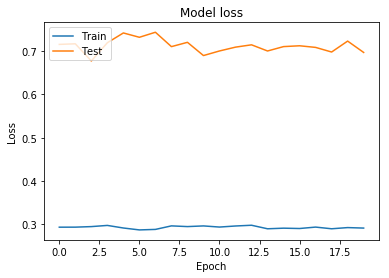

In [485]:
plt.figure()
plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Note!:** Definitely, the multistream ConvLSTM model overfits the data. However, my intention was not to tune optimally the model or to make it much deeper, but to show another more sophisticated Deep Learning approach for similar cases, since this method can be quite flexible and effective to complex Time-Series-related problems.

## Vector Autoregressive Moving Average (VARMA)

### Load the data

In [631]:
input_data = pd.read_csv('inputs.csv',header=None)
output_data = pd.read_csv('outputs.csv',header=None)
original_data = pd.DataFrame()
original_data[0] = input_data.iloc[:,0].copy()
original_data[1] = input_data.iloc[:,1].copy()
original_data[2] = input_data.iloc[:,2].copy()
original_data[3] = output_data.copy()
original_data = abs(original_data)

In [632]:
original_data.shape

(1000, 4)

In [633]:
original_data.head()

,0,1,2,3
0,1253.688798,43.459183,0.081048,0.662891
1,1253.658489,1.849287,0.104586,0.006388
2,1253.682101,88.224989,0.110097,0.613494
3,1253.691660,81.198326,0.143408,0.664729
4,1253.638780,122.391441,0.168541,0.175758


In [635]:
original_data.shape

(1000, 4)

In [636]:
original_data.head()

,0,1,2,3
0,1253.688798,43.459183,0.081048,0.662891
1,1253.658489,1.849287,0.104586,0.006388
2,1253.682101,88.224989,0.110097,0.613494
3,1253.691660,81.198326,0.143408,0.664729
4,1253.638780,122.391441,0.168541,0.175758


In [638]:
log_data = original_data.copy()

In [639]:
input0_log = np.log(original_data[0])
input1_log = np.log(original_data[1])
input2_log = np.log(original_data[2])
input3_log = np.log(original_data[3])

In [640]:
log_data.iloc[:,0] = input0_log
log_data.iloc[:,1] = input1_log
log_data.iloc[:,2] = input2_log
log_data.iloc[:,3] = input3_log

In [651]:
diff_log_data = original_data.copy()
diff_log_data.iloc[:,0] = input0_log - input0_log.shift() 
diff_log_data.iloc[:,1] = input1_log - input1_log.shift()
diff_log_data.iloc[:,2] = input2_log - input2_log.shift()
diff_log_data.iloc[:,3] = input3_log - input3_log.shift()

### ACF and PACF

In [652]:
acf_res0 = acf(diff_log_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill'), nlags=20)
pacf_res0 = pacf(diff_log_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill'), nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

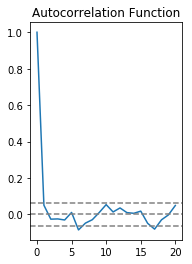

In [653]:
# ACF
plt.subplot(121) 
plt.plot(acf_res0)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [654]:
acf_res0 # thus, q = 1

array([ 1.        ,  0.05029848, -0.02620841, -0.02481431, -0.03067282,
        0.01074094, -0.08520375, -0.0479311 , -0.02908859,  0.01050117,
        0.05372337,  0.01334592,  0.03546225,  0.00978187,  0.0059676 ,
        0.01789002, -0.0491252 , -0.08093466, -0.02970942, -0.00270104,
        0.04897069])

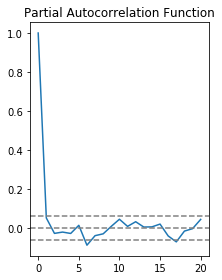

In [655]:
# PACF
plt.subplot(122)
plt.plot(pacf_res0)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,0].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [656]:
pacf_res0 # thus, p = 1

array([ 1.        ,  0.05030136, -0.02879624, -0.02210149, -0.02915148,
        0.01263199, -0.08940749, -0.04049093, -0.03103248,  0.00753658,
        0.04381806,  0.0071524 ,  0.0310562 ,  0.00376544,  0.00466348,
        0.01895428, -0.04191317, -0.07234355, -0.01703115, -0.00456623,
        0.04299304])

In [657]:
acf_res1 = acf(diff_log_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill'), nlags=20)
pacf_res1 = pacf(diff_log_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill'), nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

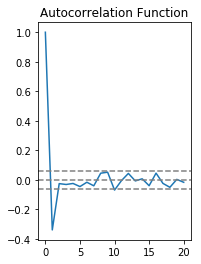

In [658]:
# ACF
plt.subplot(121) 
plt.plot(acf_res1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [659]:
acf_res1 # thus, q = 2 (the first value entered into the CI)

array([ 1.        , -0.33937716, -0.02571299, -0.03153333, -0.02456967,
       -0.04570493, -0.0163557 , -0.04054878,  0.04490558,  0.05178526,
       -0.06955691, -0.00528085,  0.0434736 , -0.00734833,  0.00686758,
       -0.03986917,  0.04525684, -0.02431474, -0.05060603,  0.00298933,
       -0.01676036])

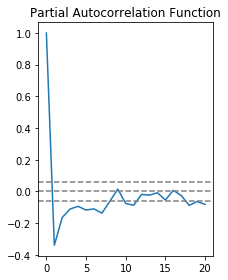

In [660]:
# PACF
plt.subplot(122)
plt.plot(pacf_res1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,1].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [661]:
pacf_res1 # thus, p = 9

array([ 1.        , -0.33938943, -0.16426037, -0.11079015, -0.09414059,
       -0.11747609, -0.11028009, -0.13718098, -0.06226487,  0.01485127,
       -0.07649347, -0.08709192, -0.01882781, -0.02329663, -0.00832611,
       -0.05426712,  0.00688848, -0.02566566, -0.08820919, -0.06383529,
       -0.08220568])

In [662]:
acf_res2 = acf(diff_log_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill'), nlags=20)
pacf_res2 = pacf(diff_log_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill'), nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

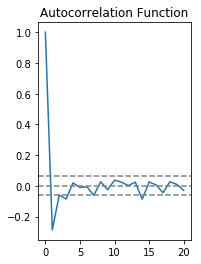

In [663]:
# ACF
plt.subplot(121) 
plt.plot(acf_res2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [664]:
acf_res2 # thus, q = 4

array([ 1.        , -0.28689322, -0.06041183, -0.0860023 ,  0.01940829,
       -0.0107539 , -0.00558346, -0.06144893,  0.02647334, -0.02561025,
        0.03758523,  0.02371048,  0.00210938,  0.02383984, -0.08715249,
        0.02511504,  0.00656581, -0.04509137,  0.0261135 ,  0.00950187,
       -0.02938273])

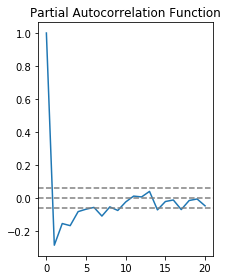

In [665]:
# PACF
plt.subplot(122)
plt.plot(pacf_res2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,2].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [666]:
pacf_res2 # thus, p = 10

array([ 1.        , -0.28689393, -0.15557623, -0.16833085, -0.08335765,
       -0.06859835, -0.05762604, -0.11024153, -0.05449507, -0.07631696,
       -0.02461524,  0.01087177,  0.00581514,  0.0393474 , -0.0726894 ,
       -0.0220541 , -0.01262848, -0.07076004, -0.01581067, -0.00666475,
       -0.04823266])

In [667]:
acf_res3 = acf(diff_log_data.iloc[:,3].fillna(method='ffill').fillna(method='bfill'), nlags=20)
pacf_res3 = pacf(diff_log_data.iloc[:,3].fillna(method='ffill').fillna(method='bfill'), nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

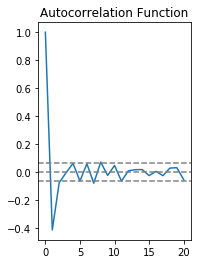

In [668]:
# ACF
plt.subplot(121) 
plt.plot(acf_res3)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,3].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,3].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [670]:
acf_res3 # thus, q = 2

array([ 1.        , -0.41588243, -0.07728142, -0.00575382,  0.06097565,
       -0.06592433,  0.05773014, -0.0810148 ,  0.0697737 , -0.02561521,
        0.0455647 , -0.06656749,  0.00769899,  0.01551096,  0.01631343,
       -0.02661052,  0.00302115, -0.02727417,  0.02672701,  0.03004457,
       -0.05542527])

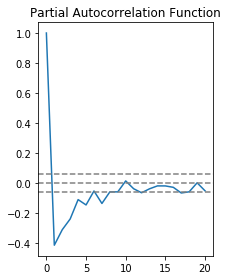

In [671]:
# PACF
plt.subplot(122)
plt.plot(pacf_res3)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_data.iloc[:,3].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_data.iloc[:,3].fillna(method='ffill').fillna(method='bfill'))),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [673]:
pacf_res3 # thus, p = 6

array([ 1.00000000e+00, -4.16040875e-01, -3.12762681e-01, -2.40948405e-01,
       -1.11867224e-01, -1.47438352e-01, -5.42045057e-02, -1.37615828e-01,
       -6.02626470e-02, -6.02208295e-02,  1.27555631e-02, -3.92842375e-02,
       -6.61618100e-02, -3.97466459e-02, -2.03160228e-02, -2.05379382e-02,
       -2.98319107e-02, -6.75814632e-02, -5.98292065e-02,  3.75515946e-04,
       -5.32342517e-02])

Consequently, the overall order is the following tuple (satisfying all variables): (1,1)

In [678]:
varma_order = (1,1)
data = np.transpose(np.vstack([input0_log.fillna(method='ffill').fillna(method='bfill'), 
        input1_log.fillna(method='ffill').fillna(method='bfill'), 
        input2_log.fillna(method='ffill').fillna(method='bfill'),
        input3_log.fillna(method='ffill').fillna(method='bfill')]))
# data = [input_data0, input_data1, input_data2]

In [679]:
data.shape

(1000, 4)

In [680]:
varma_model = VARMAX(data, order=varma_order) # or input_data
varma_model_fit = varma_model.fit(disp=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [681]:
varma_model_fit.fittedvalues.shape # but in this particular case, we are interested only in the last column

(1000, 4)

In [682]:
predictions_varma_diff = varma_model_fit.fittedvalues[:,-1]

In [683]:
predictions_varma_diff.shape

(1000,)

In [684]:
# predictions_varma_diff = input_data.copy()
# predictions_varma_diff = predictions_varma_diff.iloc[0:0]
# predictions_varma_diff.iloc[:,0] = varma_model_fit.fittedvalues[:,0]
# predictions_varma_diff.iloc[:,1] = varma_model_fit.fittedvalues[:,1]
# predictions_varma_diff.iloc[:,2] = varma_model_fit.fittedvalues[:,2]

In [685]:
predictions_varma_diff_cumsum = predictions_varma_diff.cumsum()
# predictions_varma_log = pd.Series(data.ix[0], index=data.index)
data = pd.DataFrame(data[:,-1])
predictions_varma_diff_cumsum = pd.DataFrame(predictions_varma_diff_cumsum)

In [686]:
predictions_varma_diff_cumsum.head()

,0
0,-1.042885
1,-1.903154
2,-3.619173
3,-4.614385
4,-5.458498


In [687]:
predictions_varma_log = data.add(predictions_varma_diff_cumsum,fill_value=0)
predictions_varma = np.exp(predictions_varma_log)

In [688]:
predictions_varma.shape

(1000, 1)

In [703]:
print('RMSE: %.4f'% np.mean((predictions_varma - output_data)**2))

RMSE: 0.4273
